<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Markov Chains and PageRank</h1>
<h1>Quantifying node importance</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

import sklearn
from sklearn.linear_model import LinearRegression

import tqdm as tq
from tqdm import tqdm

import pandas as pd
import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

Watermark the notebook with current versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 027e0ade637b422d3fb6214f2c2a3489943d55b8

sklearn   : 0.0
matplotlib: 3.3.2
pandas    : 1.1.3
watermark : 2.1.0
json      : 2.0.9
tqdm      : 4.62.0
networkx  : 2.5
numpy     : 1.19.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
seed = np.random.randint(100)

And capture all the configurations over the course of 100 timesteps

## Random Walks and Paths

In [5]:
edges = pd.read_csv('data/higgs_SCC.dat.gz', sep=' ', header=None)
edges[2] = 1

In [6]:
G = nx.DiGraph()
G.add_weighted_edges_from(edges.values)

In total, we have

In [7]:
N = G.number_of_nodes()
E = G.number_of_edges()
print(f"Number of nodes: {N}\nNumber of Edges {E}")

Number of nodes: 322
Number of Edges 708


In [8]:
np.random.seed(42)
random.seed(42)
pos = nx.layout.kamada_kawai_layout(G)

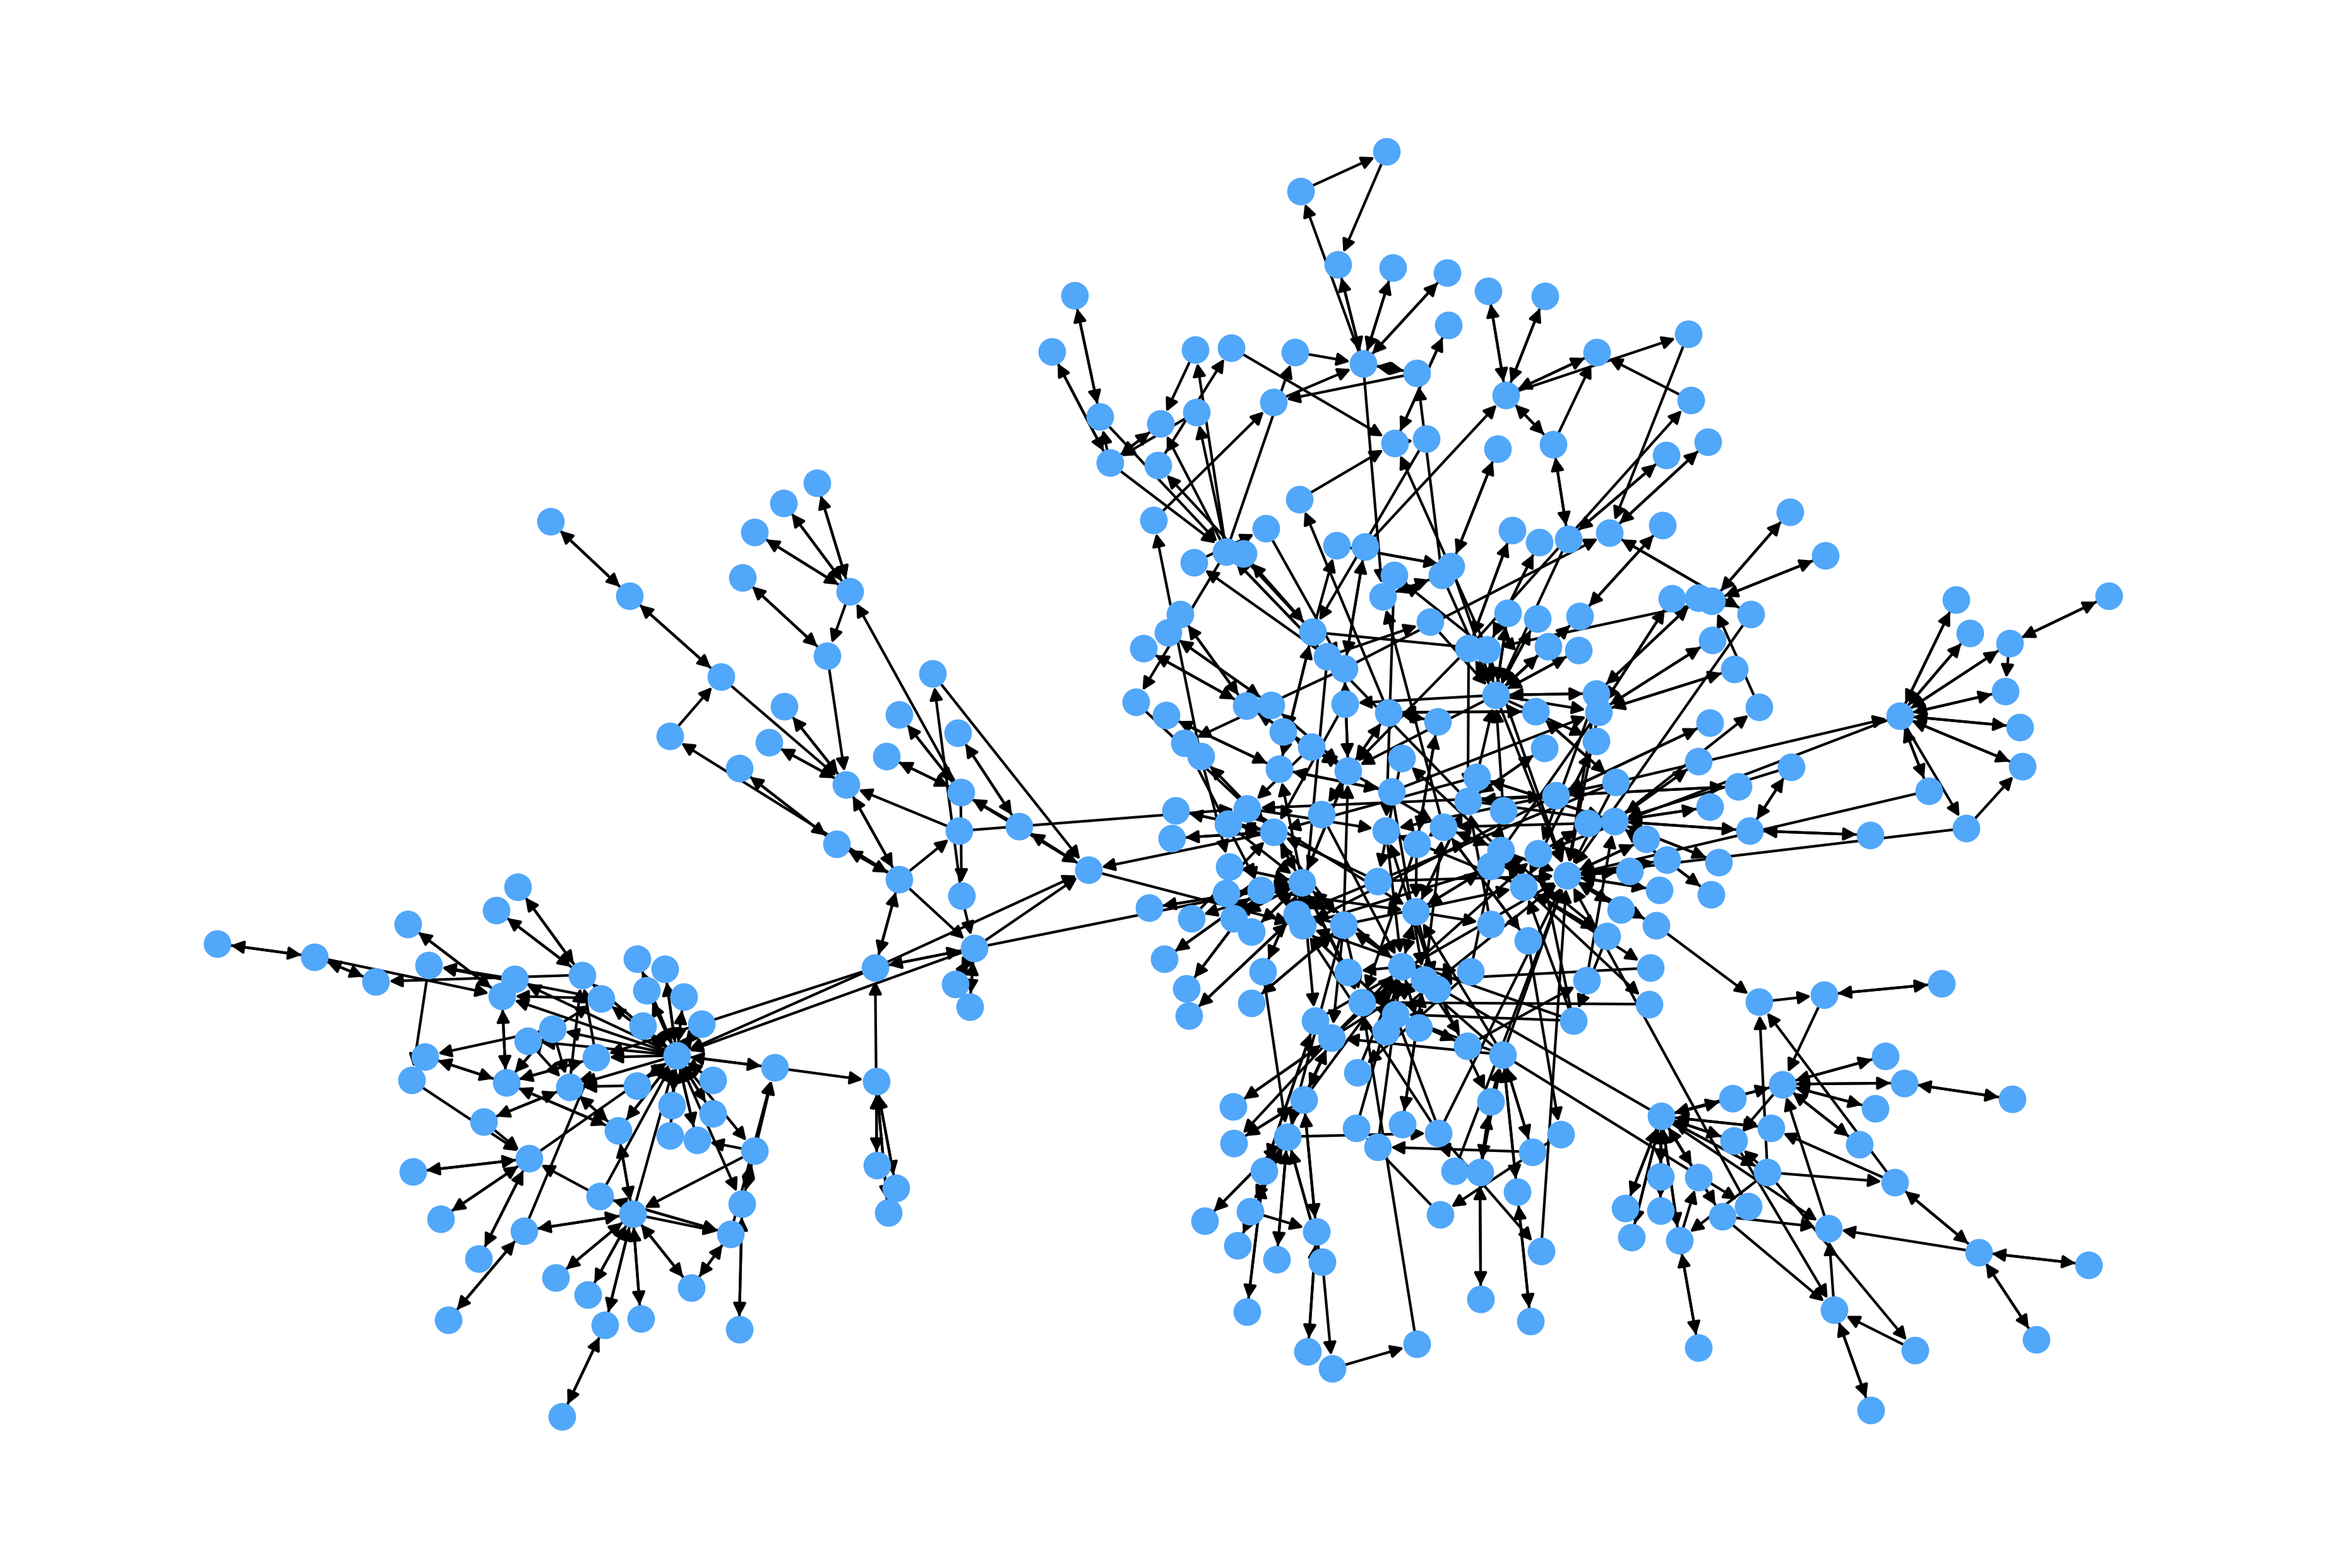

In [9]:
nx.draw_networkx_edges(G, pos=pos, node_size=100)
nx.draw_networkx_nodes(G, pos=pos, node_size=100, node_color=colors[0])
plt.gca().axis('off');

As we saw, a path on a graph is simply a sequence of visited nodes. Here we implement a simple Random Walk over a graph to generate the sequence of visited nodes. 

In [10]:
def random_walk(G, source, steps):
    path = [source]
    
    for i in tqdm(range(steps), total=steps):
        source = path[-1]
        NN = list(G.neighbors(source))
        if len(NN) == 0:
            continue
        
        chosen = NN[np.random.randint(len(NN))]
        path.append(chosen)
        
    return path

We generate a path of 1,000,000 steps

In [11]:
path = random_walk(G, 135185, 1_000_000)

100%|██████████| 1000000/1000000 [00:03<00:00, 284600.05it/s]


And count how many times each node is visited

In [12]:
node_data = pd.DataFrame.from_dict(Counter(path).items())
node_data.columns = ['node', 'visits']

The top 10 most visited nodes are:

In [13]:
node_data.sort_values('visits', ascending=False)[:10]

,node,visits
5,36436,109689
8,52908,82092
80,677,72562
11,52926,36465
14,52150,30936
13,49610,25119
10,119268,23513
21,13808,20462
7,164767,18434
15,80787,18317


For comparison, we also compute their in-degrees:

In [14]:
node_data['degree'] = node_data['node'].map(lambda x: G.in_degree(x))

And we clearly see that the number of visits is strongly correlated with the node degree. To make it clearer

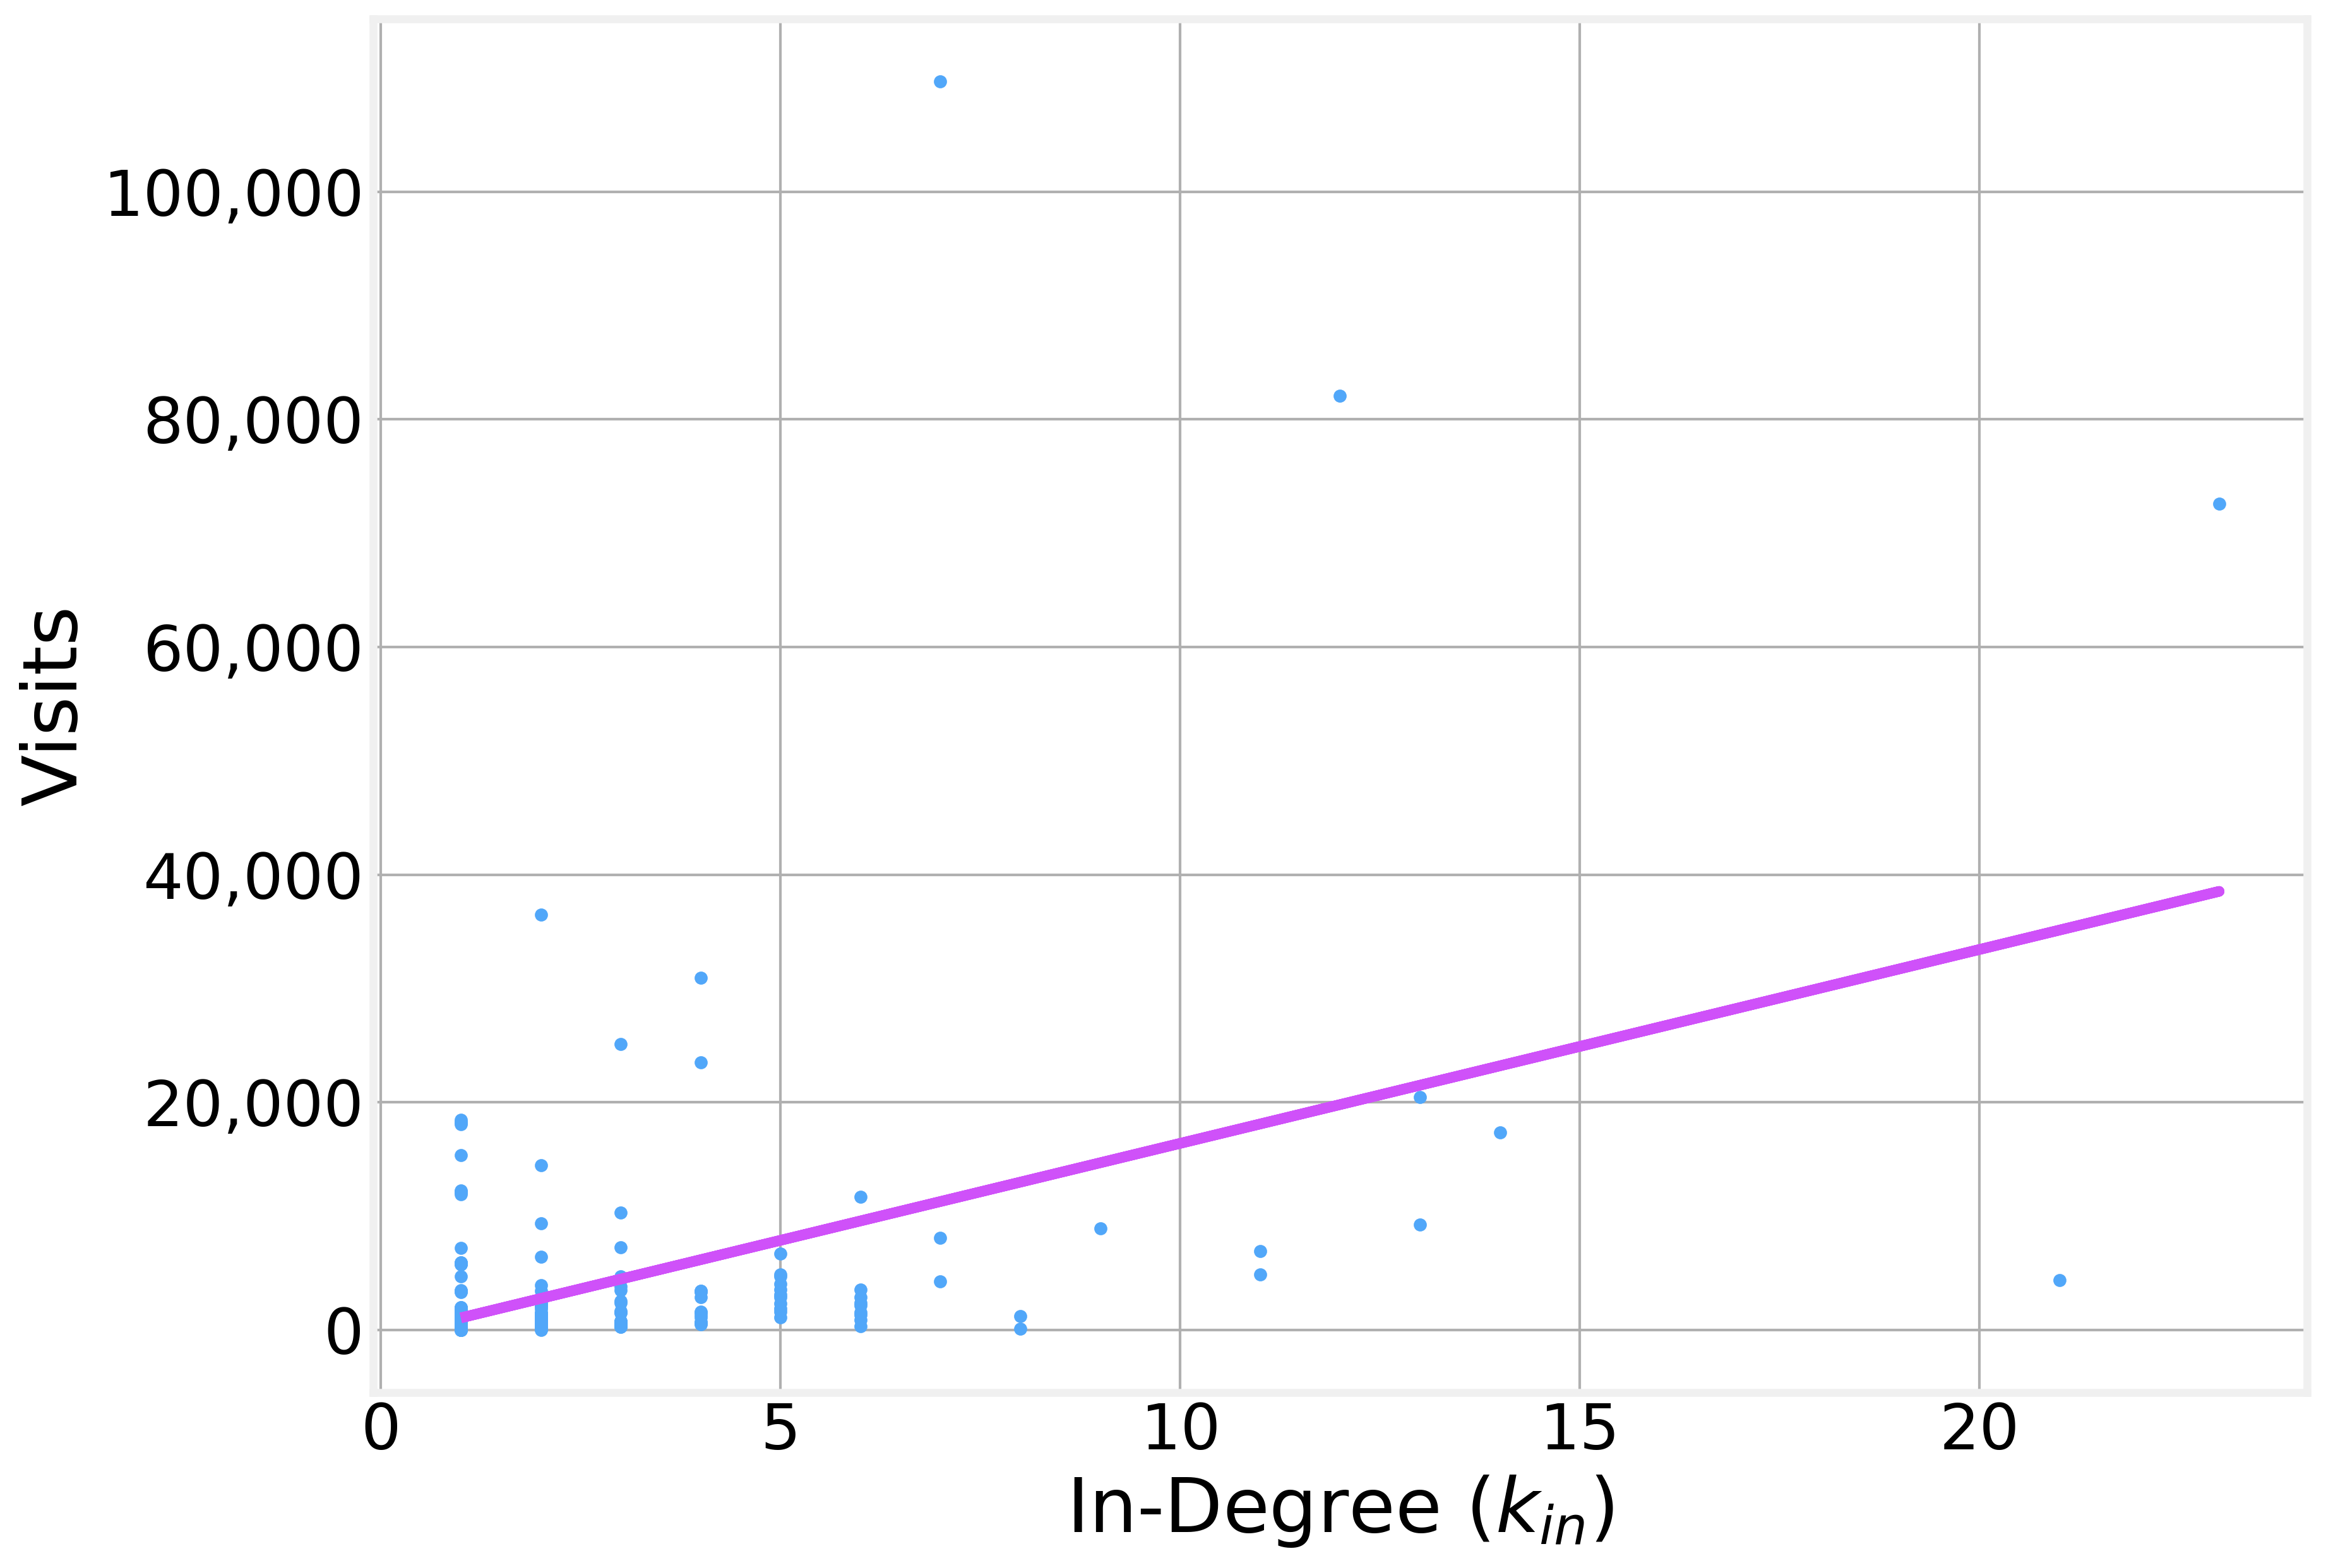

In [15]:
lm = LinearRegression(fit_intercept=True)
lm.fit(node_data['degree'].values.reshape(-1, 1), node_data['visits'])

ax = node_data.plot.scatter(x='degree', y='visits')
ax.plot(node_data['degree'].values, 
        lm.predict(node_data['degree'].values.reshape(-1, 1)), '-',
        color=colors[1])
ax.set_xlabel(r'In-Degree $\left(k_{in}\right)$')
ax.set_ylabel('Visits')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

In [16]:
max_degree = node_data['degree'].max()
max_visits = node_data['visits'].max()
node_data['sizes'] = node_data['degree']/max_degree*600
node_data['visits_color'] = node_data['visits']/max_visits

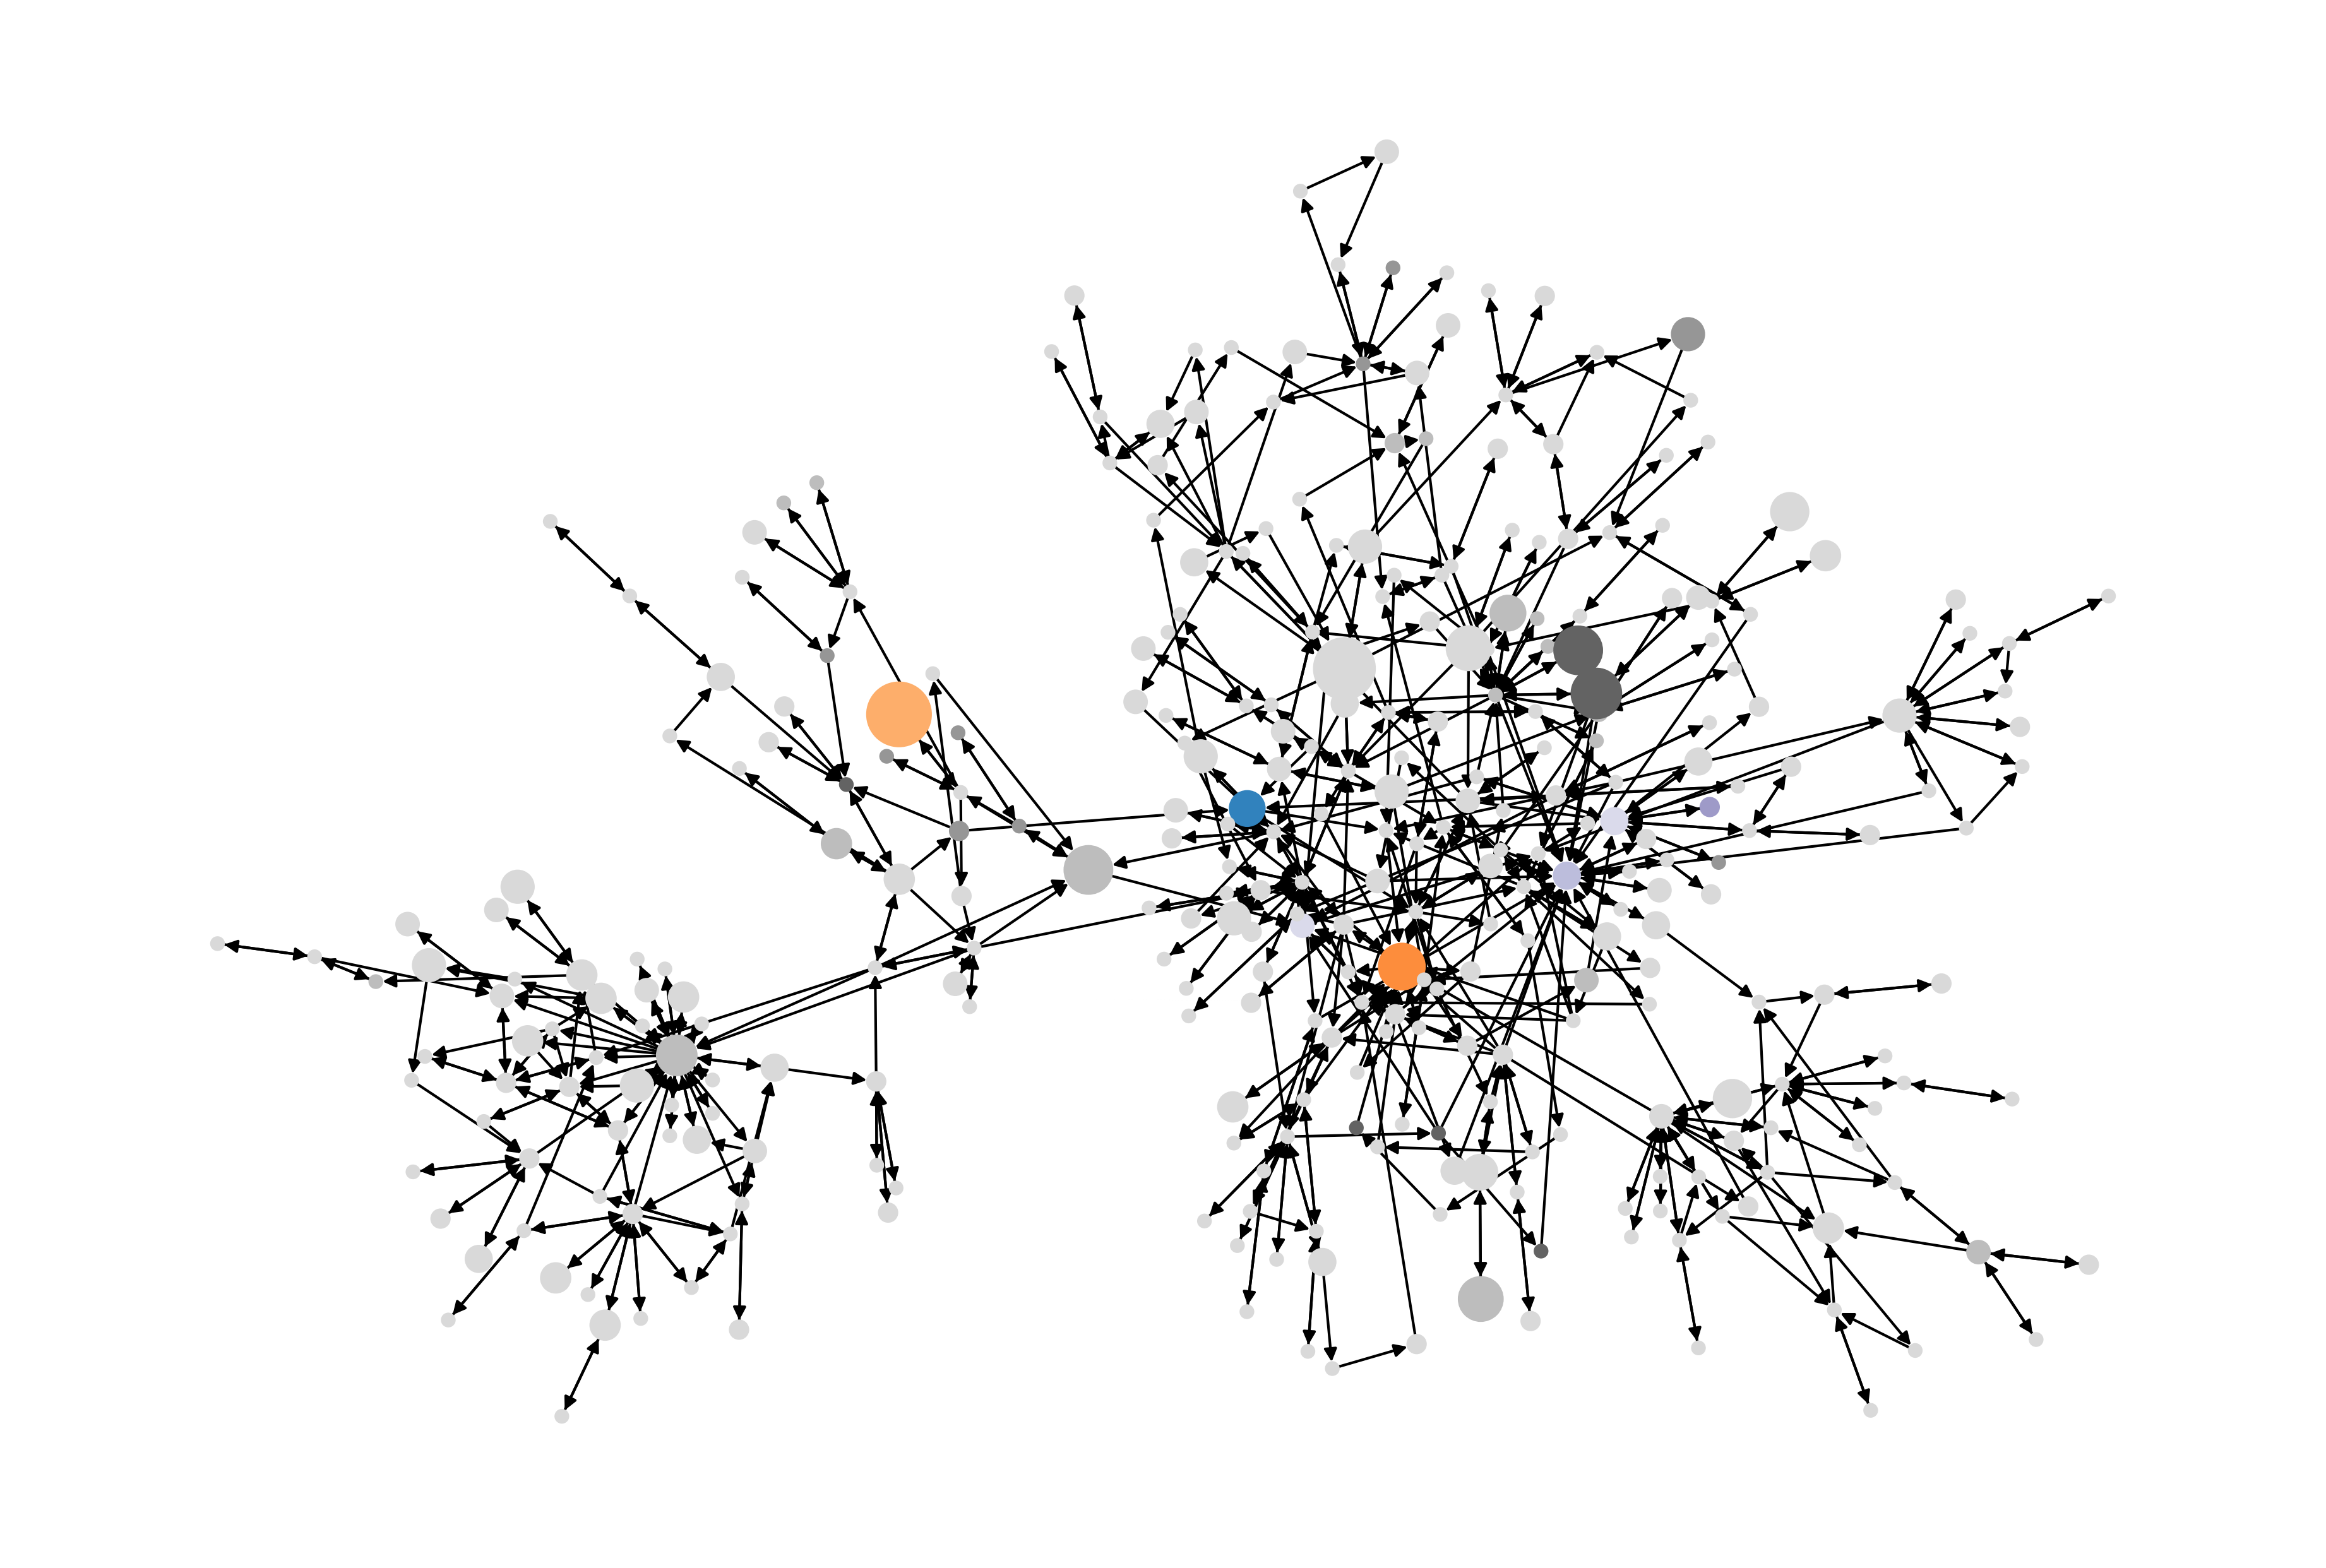

In [17]:
nx.draw_networkx_edges(G, pos=pos, node_size=node_data['sizes'])
nx.draw_networkx_nodes(G, pos=pos, node_size=node_data['sizes'],
                       node_color=plt.cm.tab20c_r(node_data['visits_color'].values)
                      )
plt.gca().axis('off');

## PageRank

The first step is generating the Google Matrix of the graph. For this we require the adjacency matrix, so we start there

In [18]:
def adjacency_matrix(G):
    N = G.number_of_nodes()
    
    node_pos = dict(zip(G.nodes(), np.arange(N)))
    
    A = np.zeros((N, N), dtype='float')
    
    for node_i, node_j in G.edges():
        pos_i = node_pos[node_i]
        pos_j = node_pos[node_j]

        A[pos_i, pos_j] = 1
            
    return A, node_pos

In [19]:
A, node_pos = adjacency_matrix(G)

The Google Matrix is then given by:

In [20]:
def google_matrix(G, m):
    A, node_pos = adjacency_matrix(G)
    N = A.shape[0]

    v = np.ones(N)
    KT = np.dot(A, v)
    A = A.T

    for i in range(N):
        if KT[i] != 0:
            A.T[i] = A.T[i]/KT[i]
        else:
            A.T[i] = np.ones(N)/float(N)

    S = np.ones((N, N))/N
    G = (1-m)*A+m*S

    return G

In order to calculate the pagerank value of each node we will need to use the Power Method. We define it now

In [21]:
def Power_Method(GM, x0, n_iter=1000, tol=1e-10):
    errors = []
    
    for i in range(n_iter):
        x1 = np.copy(x0)
        x0 = np.dot(GM, x0)
        
        mse = np.mean(np.abs(x1-x0))
        errors.append(mse)

        if mse < tol:
            break

    return x0, np.asarray(errors)

And now we put all the pieces together

In [22]:
Google_Matrix = google_matrix(G, 0.15)
x0 = np.ones(N)/N
pagerank, errors = Power_Method(Google_Matrix, x0)

Text(0, 0.5, 'Mean Squared Error')

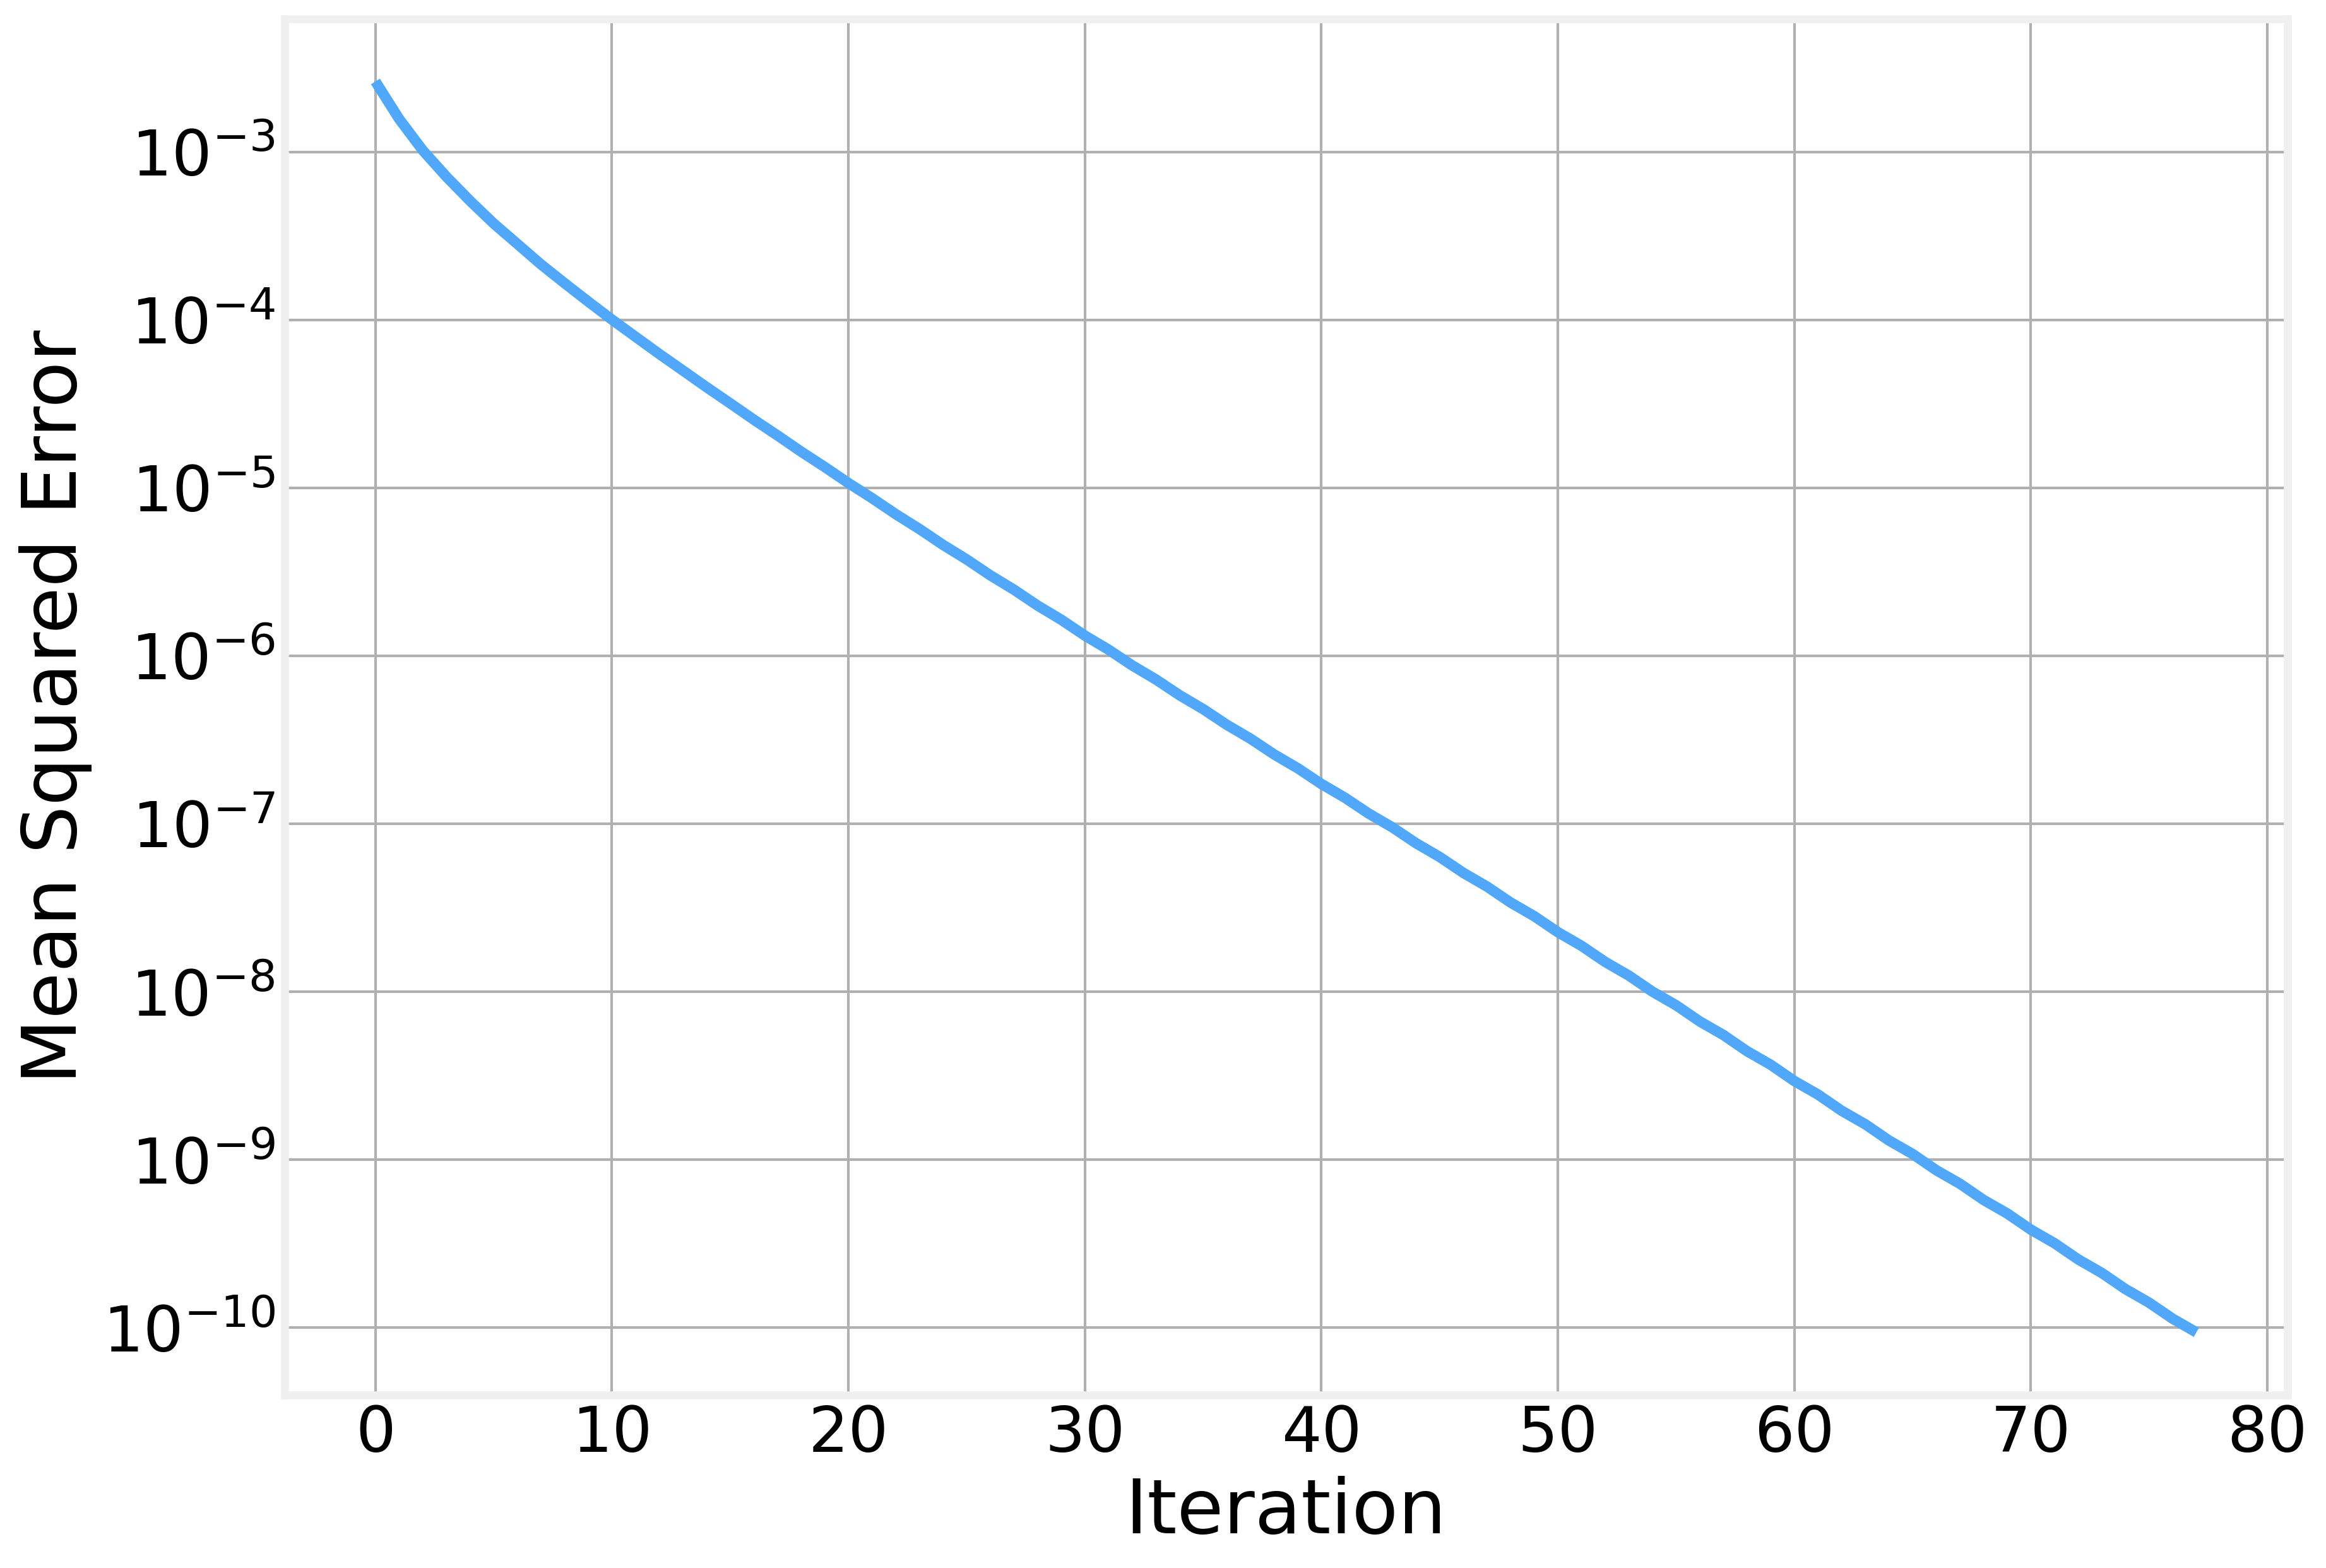

In [23]:
fig, ax = plt.subplots(1)
ax.plot(errors)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean Squared Error")

And we compare it with the degree distribution

In [24]:
node_data['pagerank'] = node_data['node'].map(lambda x: pagerank[node_pos[x]])

Text(0, 0.5, 'PageRank')

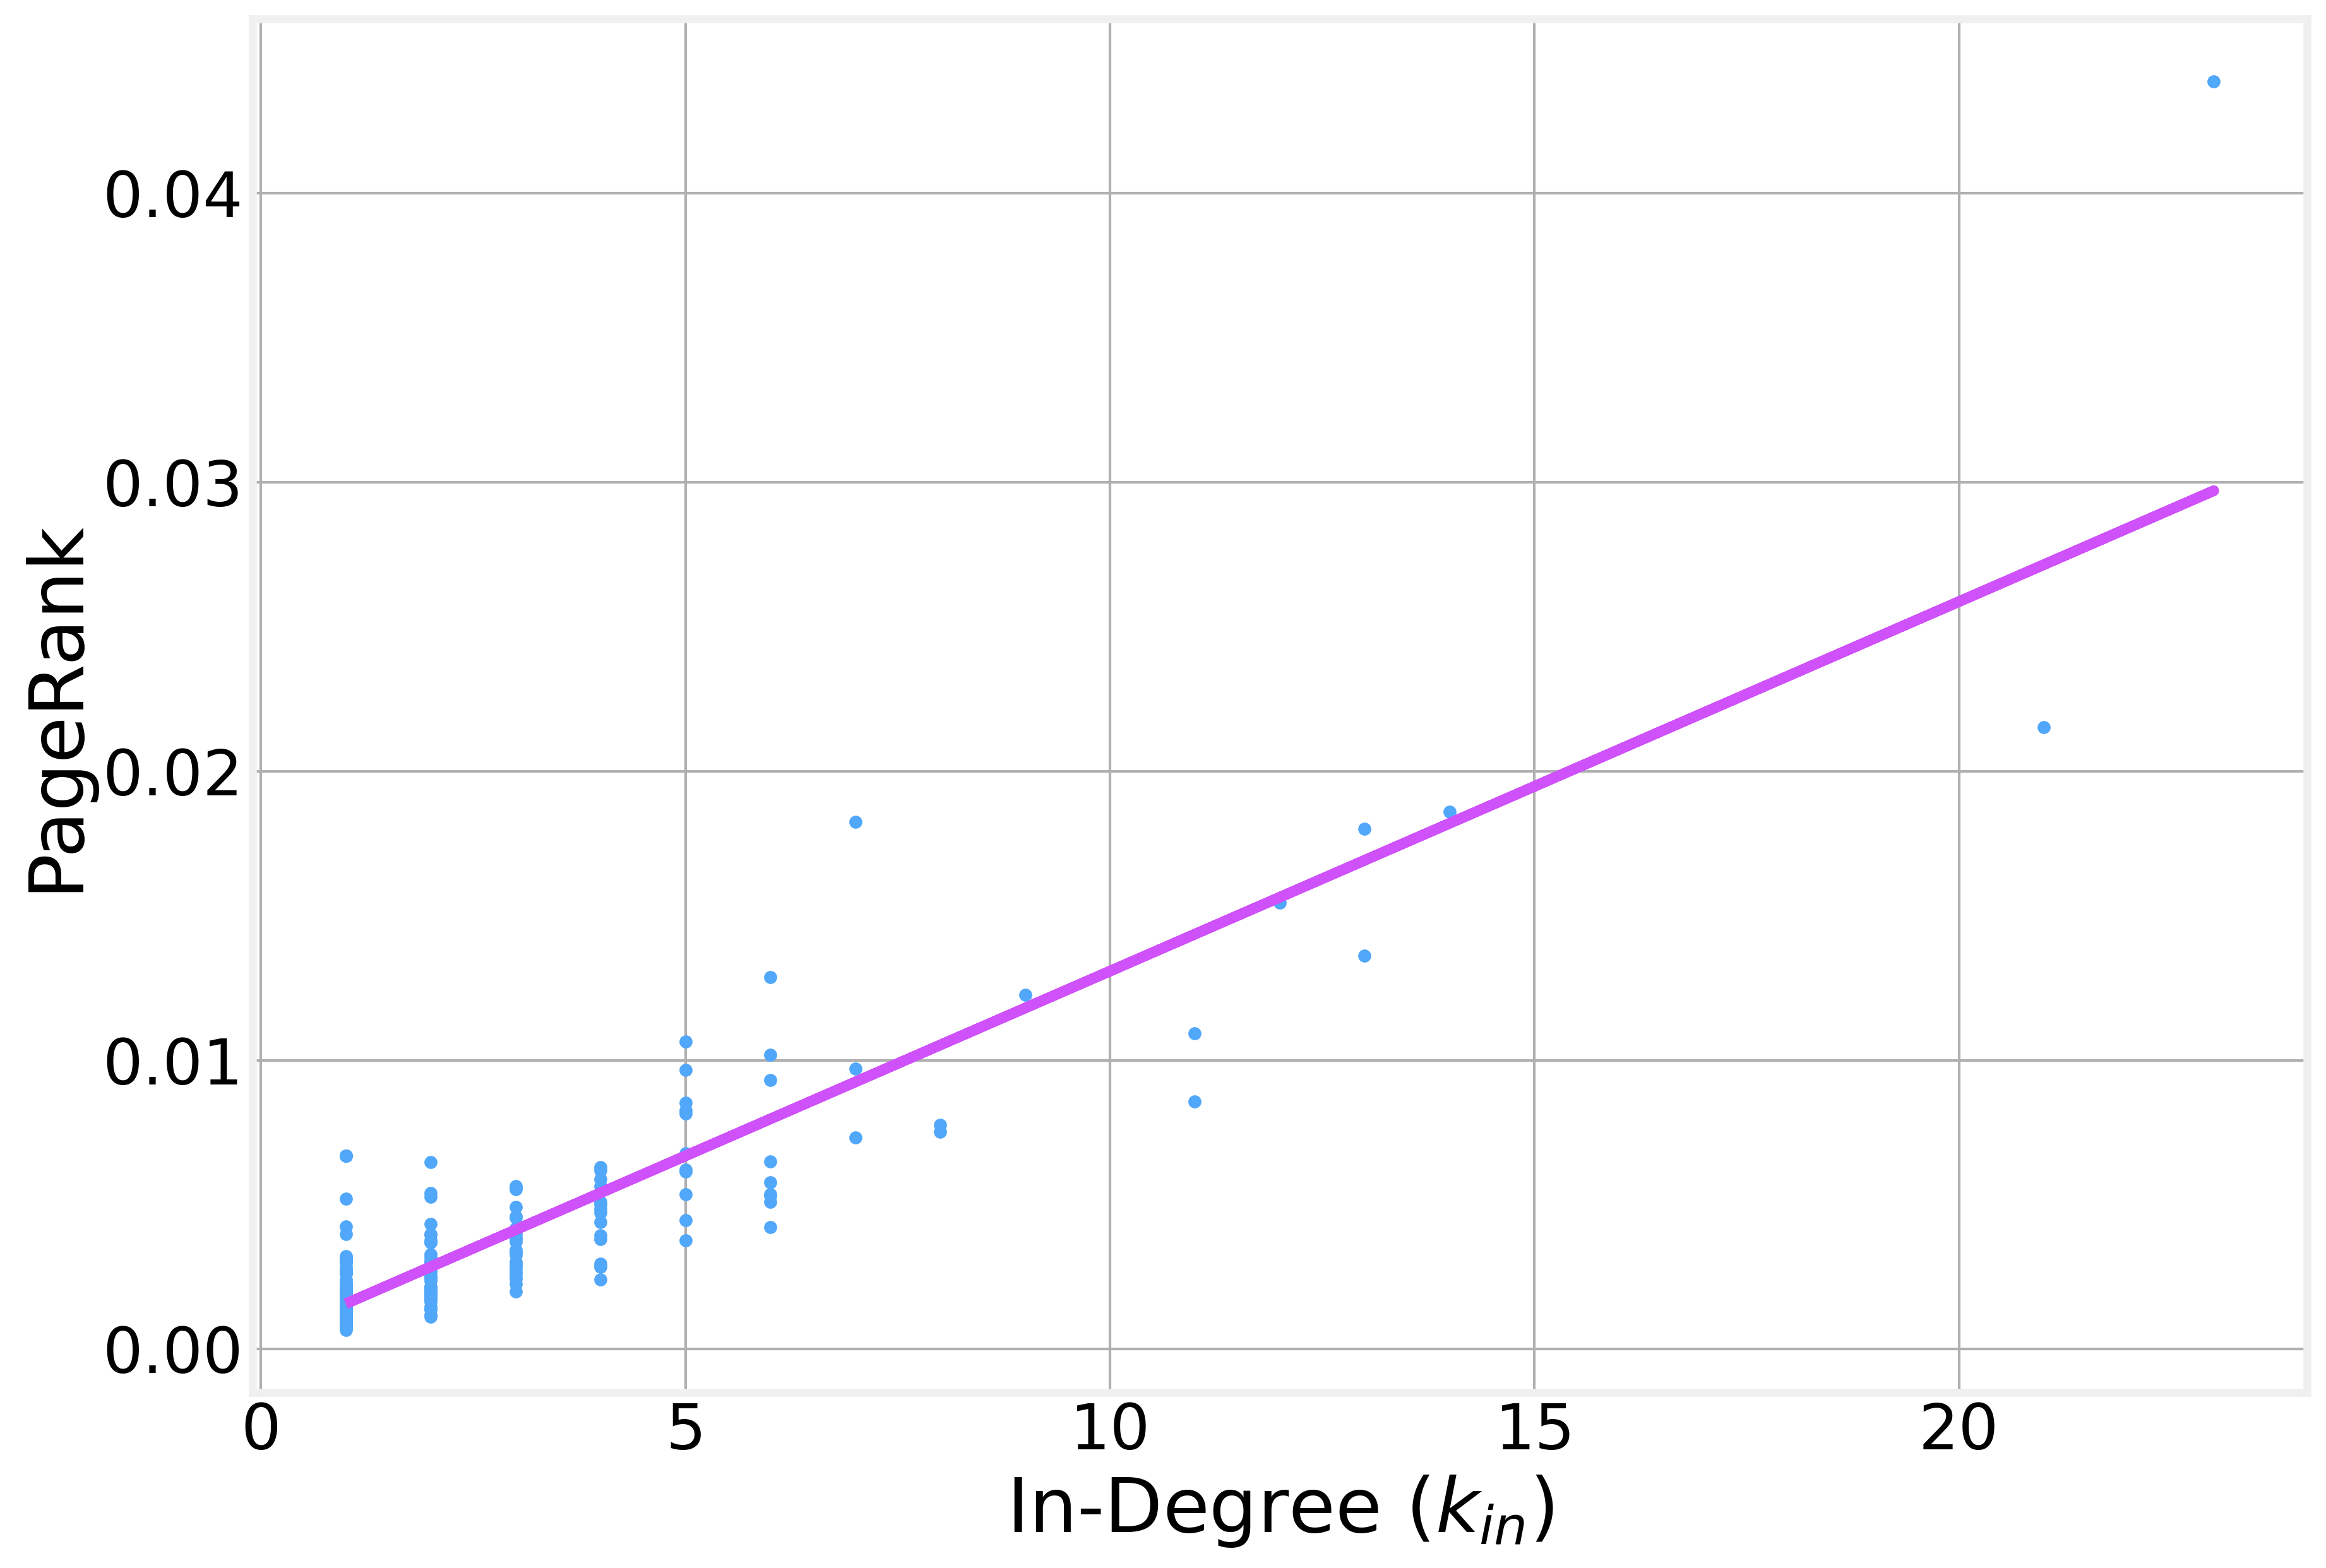

In [25]:
lm = LinearRegression(fit_intercept=True)
lm.fit(node_data['degree'].values.reshape(-1, 1), node_data['pagerank'])

ax = node_data.plot.scatter(x='degree', y='pagerank')
ax.plot(node_data['degree'].values, 
        lm.predict(node_data['degree'].values.reshape(-1, 1)), '-',
       color=colors[1])

ax.set_xlabel(r'In-Degree $\left(k_{in}\right)$')
ax.set_ylabel('PageRank')

As expected, it is strongly correlated with the degree (important pages are linked to by many other pages) but with important fluctuations due to the local network structure. These variations become even stronger in larger, directed graphs such as the WWW

In [26]:
max_pagerank = node_data['pagerank'].max()

In [27]:
node_data.sort_values('degree', inplace=True)
node_data['x'] = np.arange(node_data.shape[0])%17
node_data['y'] = np.arange(node_data.shape[0])//17

In [28]:
pos2 = dict(zip(node_data['node'].values,
          zip(node_data['x'].values, 
             node_data['y'].values)))

Assign color based on PageRank quantile

In [29]:
discrete_pagerank = ((np.linspace(0, 1, N)*20).astype('int')/20)
node_data.loc[node_data.sort_values('pagerank').index, 
              'pagerank_color'] = discrete_pagerank

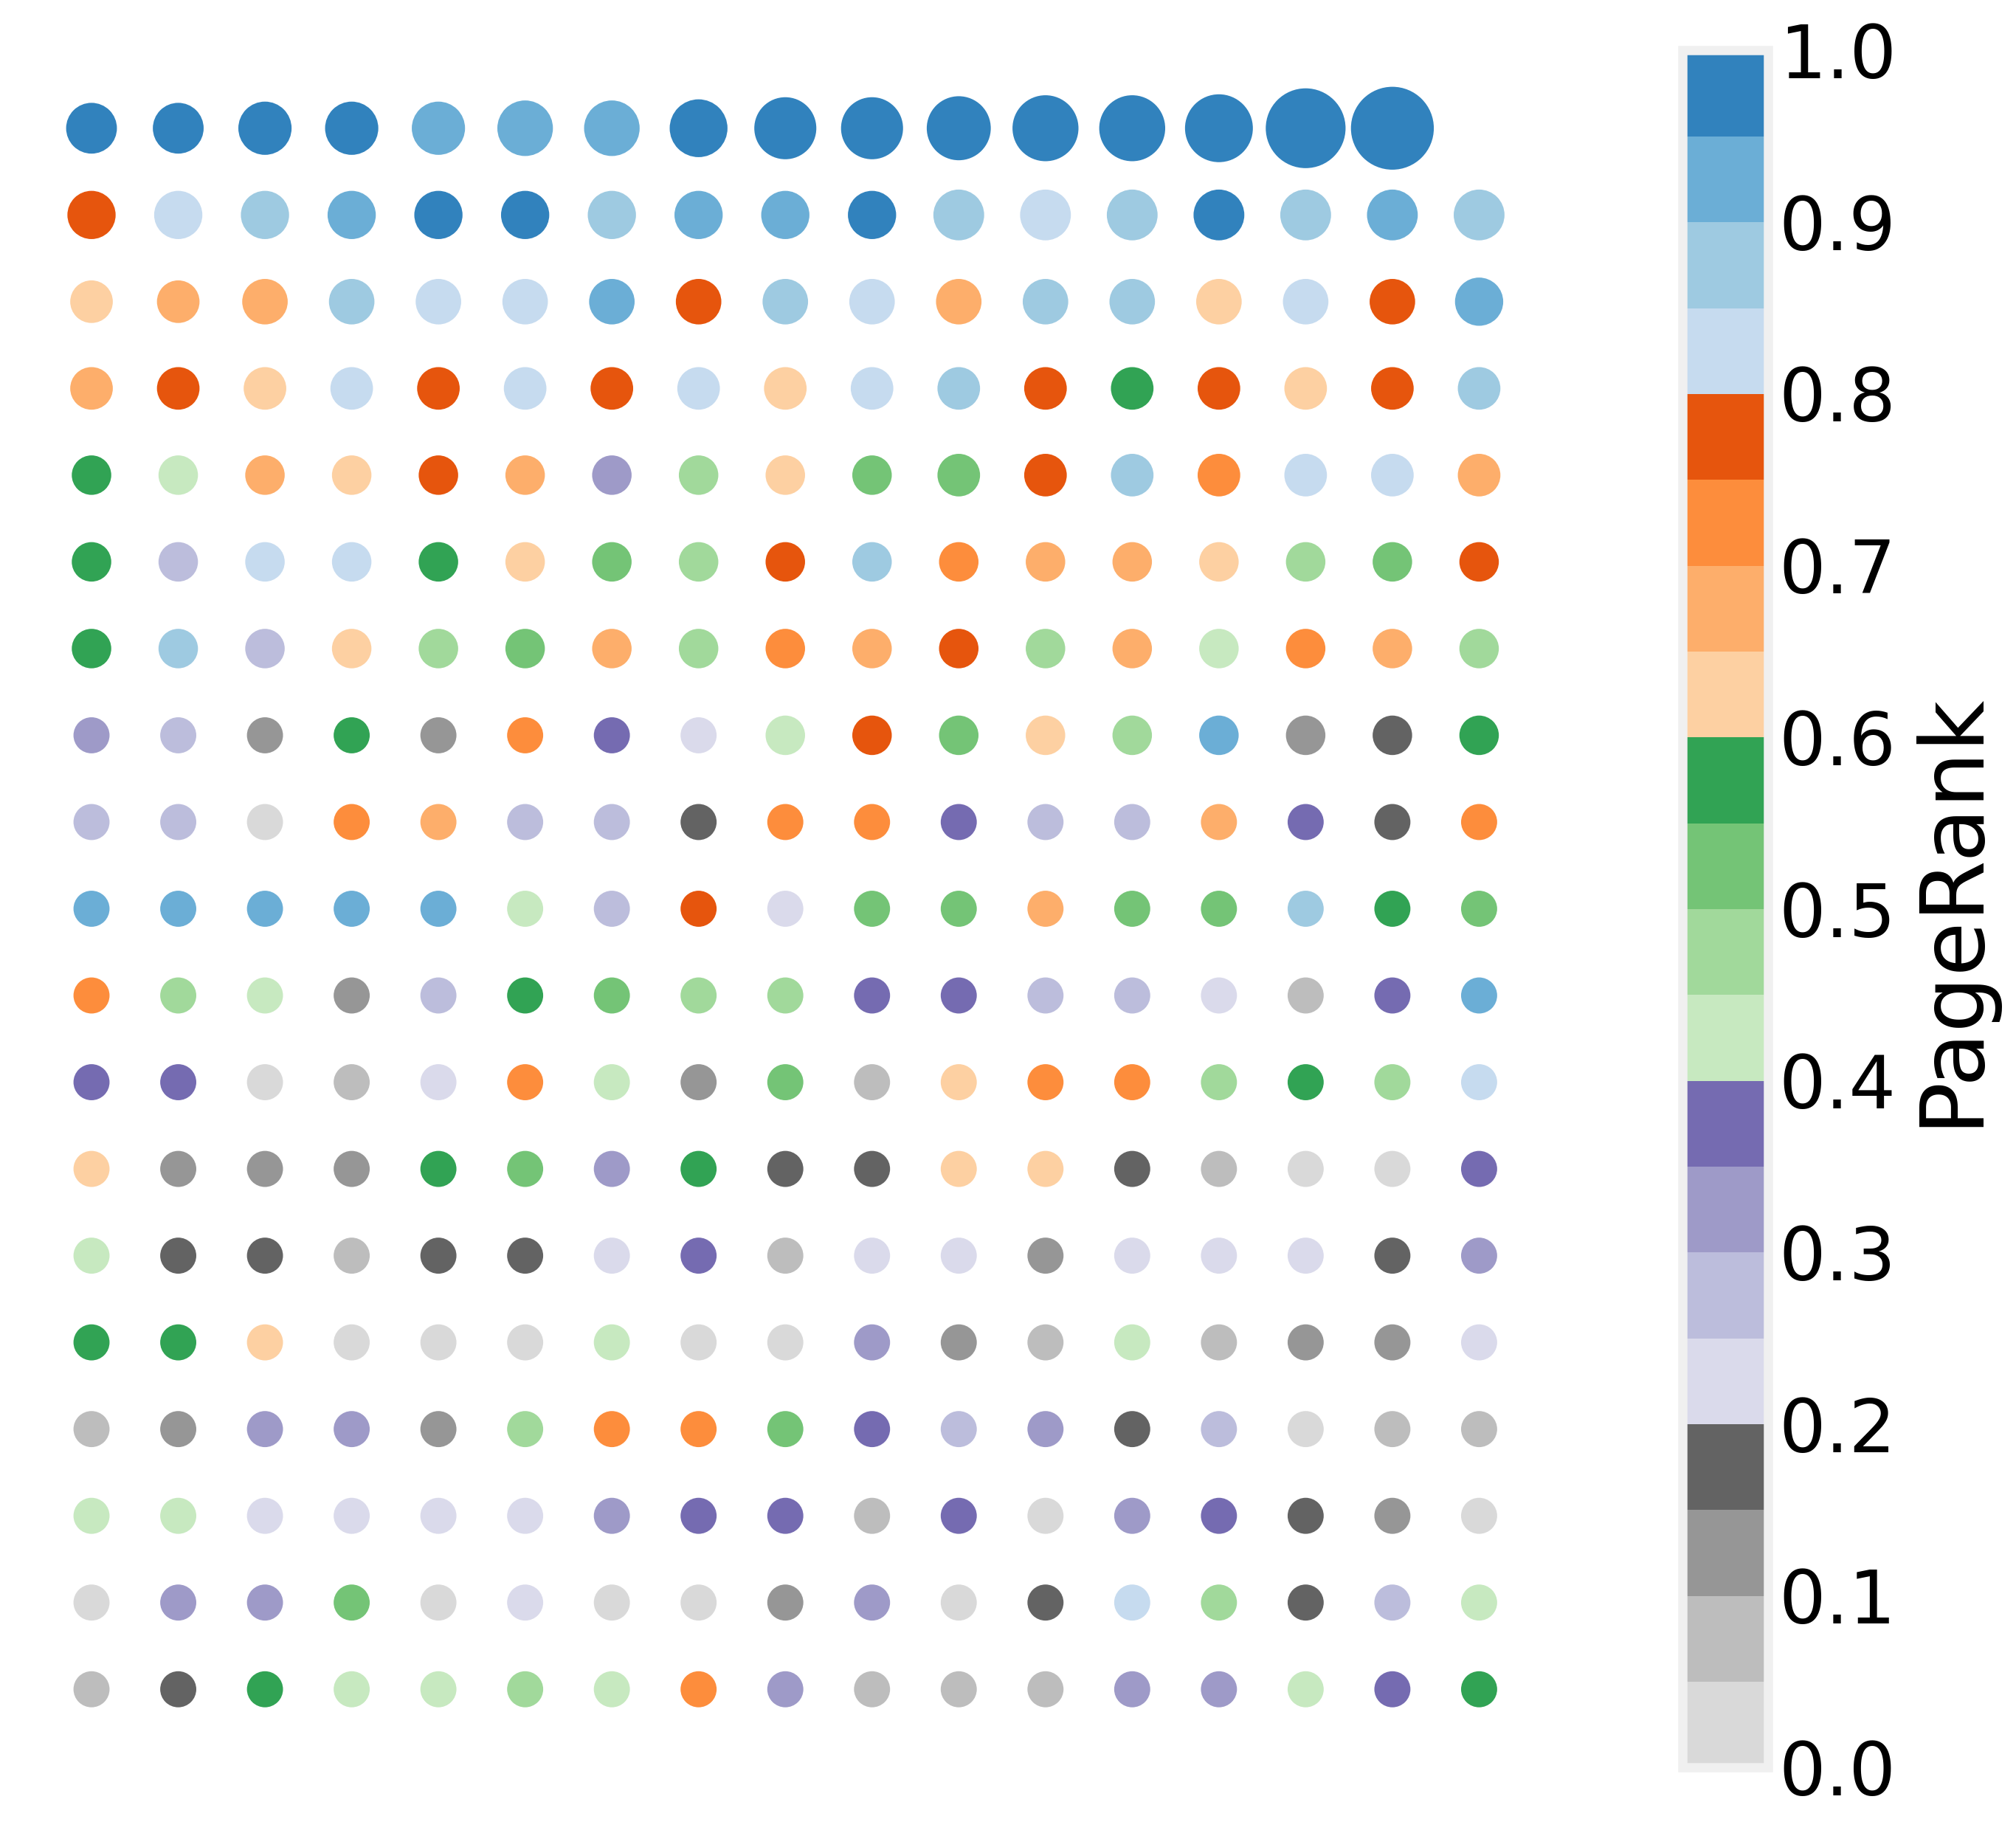

In [30]:
ax = node_data.plot.scatter(x='x', y='y', 
                            # Make nodes larger for visibility
                            s=node_data['sizes']+100, 
                            c=plt.cm.tab20c_r(node_data['pagerank_color'].values))
sm = plt.cm.ScalarMappable(cmap=plt.cm.tab20c_r)
sm.set_array([])
ax.set_aspect('equal')
plt.colorbar(sm, ticks=np.linspace(0, 1, 11), label='PageRank')
ax.axis('off');

Sort the DataFrame in the order of the graph nodes

In [31]:
node_data = node_data.set_index('node').loc[np.array(G.nodes())].reset_index()

In [ ]:
nx.draw_networkx_edges(G, pos=pos, node_size=node_data['sizes'].values)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_data['sizes'].values,
                       node_color=plt.cm.tab20c_r(
                           node_data['pagerank_color'].values)
                      )
plt.gca().axis('off');

<div style="width: 100%; overflow: hidden;">
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>